#### Required Libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
plt.style.use('default')

#### Load Train and Test Data
Data dictionary:
| Variable | Definition | Key |
|---|---|---|
| Survival | Survival | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | Sex | |
| Age | Age in years | |
| Sibsp | # of siblings / spouses aboard the Titanic | |
| Parch | # of parents / children aboard the Titanic | |
| Ticket | Ticket number | |
| Fare | Passenger fare | |
| Cabin | Cabin number | |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [23]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train.shape)
train.head()
#test.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Get unique count of each column
for i in range(len(train.columns)):
    print("Unique values in column '" + train.columns[i] + "': " + str(train[train.columns[i]].nunique()))

Unique values in column 'PassengerId': 891
Unique values in column 'Survived': 2
Unique values in column 'Pclass': 3
Unique values in column 'Name': 891
Unique values in column 'Sex': 2
Unique values in column 'Age': 88
Unique values in column 'SibSp': 7
Unique values in column 'Parch': 7
Unique values in column 'Ticket': 681
Unique values in column 'Fare': 248
Unique values in column 'Cabin': 147
Unique values in column 'Embarked': 3


#### Exploratory Data Analysis (EDA)
* Name: Too many unique values; unlikely to directly affect survival. Probably safe to drop unless extracting features like titles (e.g., Mr., Mrs.).
* Sex: Clearly important; most algorithms will need it encoded numerically (e.g., 0/1).
* Age: Continuous with many distinct values and some missing entries. Consider handling nulls and possibly binning into age groups to capture non-linear effects.
* Ticket: Very high cardinality, not obviously linked to survival. Likely safe to drop, unless patterns exist (e.g., shared ticket numbers among families).
* Fare: May carry signal—higher fares could correlate with better cabins and higher survival odds. Could use directly or after binning.
* Cabin: Both sparse and high-cardinality. Likely not useful in raw form; might drop or simplify (e.g., deck letter extraction).
* Other columns: Appear reasonable for now; keep and adjust if later analysis suggests otherwise (although I'm not sure if 'Embarked' would make a difference in the results).

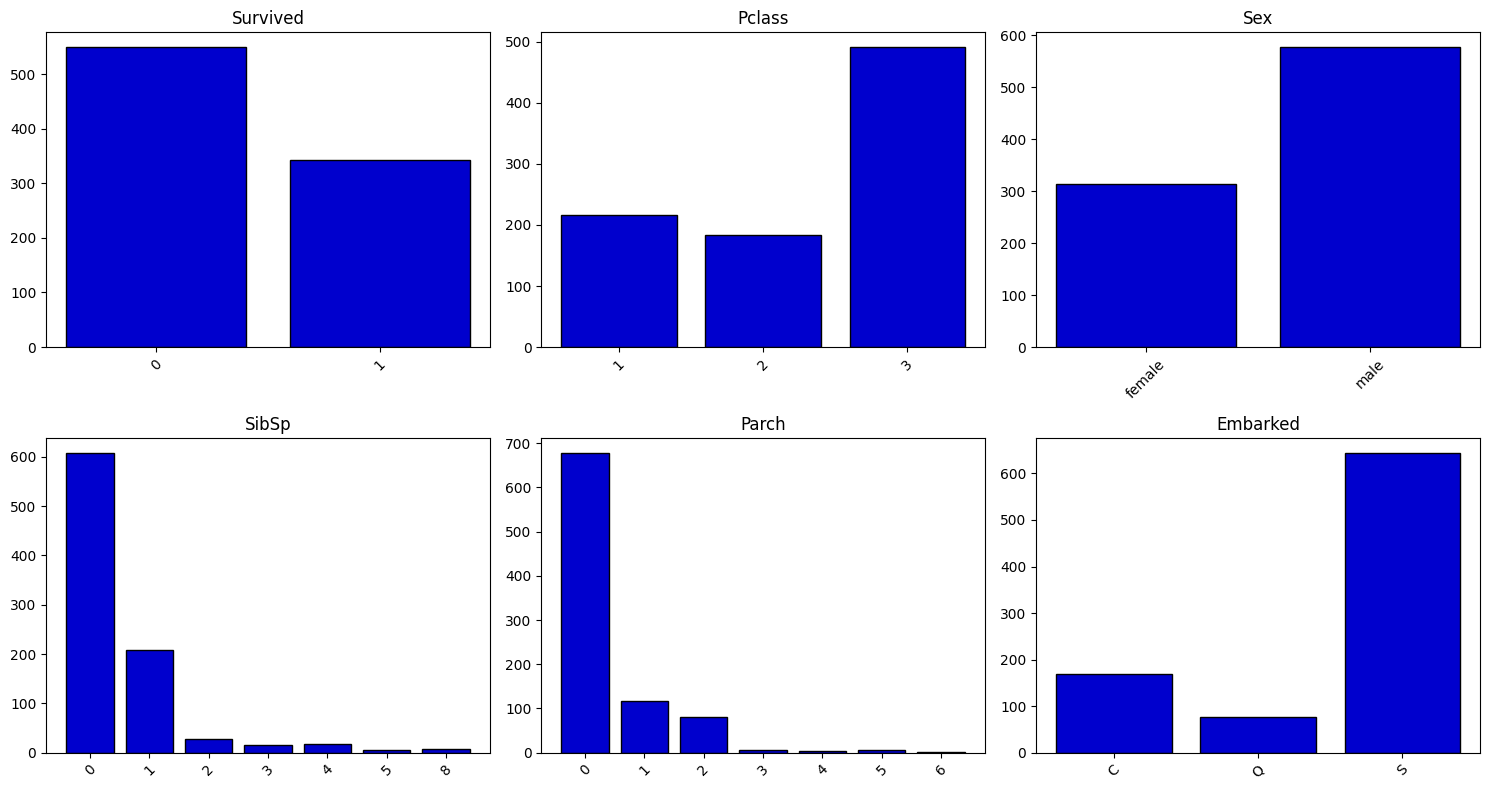

In [10]:
# Select int64, object, category type columns
cat_cols = train.select_dtypes(include=['int64', 'object', 'category']).columns
cat_cols = cat_cols.drop(['PassengerId','Name','Ticket','Cabin'])

n_cols = 3  # number of plots per row
n_rows = -(-len(cat_cols) // n_cols)  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for ax, col in zip(axes.flatten(), cat_cols):
    counts = train[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, edgecolor='k', color='mediumblue')
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

# if extra axes remain blank
for ax in axes.flatten()[len(cat_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [11]:
# Missing value handling (fill missing before looking at the distribution)
# Age
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

# Fare
train['Fare'] = train['Fare'].fillna(train['Fare'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

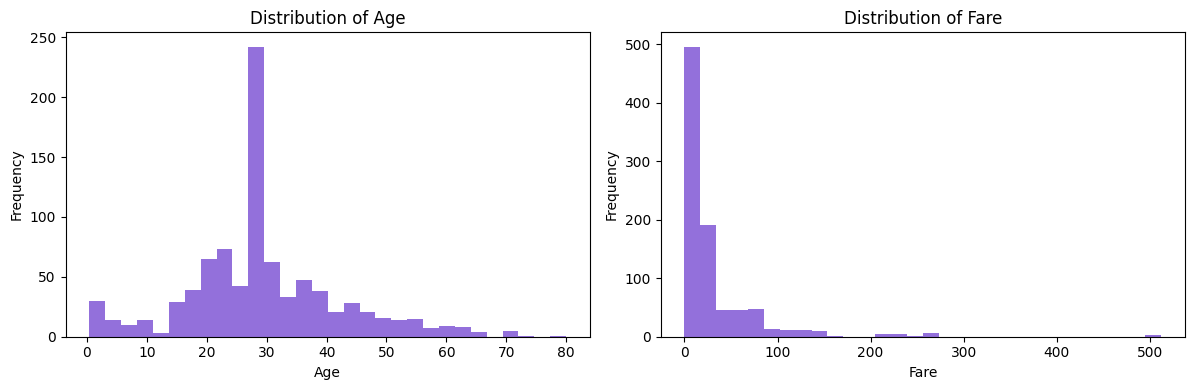

In [12]:
# Select float64 type columns
float_cols = train.select_dtypes(include='float64').columns

n_cols = 3  # how many plots per row
n_rows = -(-len(float_cols) // n_cols)  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

# Flatten axes for easy iteration (even if it's 1D)
axes = axes.flatten()

for ax, col in zip(axes, float_cols):
    ax.hist(train[col].dropna(), bins=30, color='mediumpurple')
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

# Remove any unused subplots if float_cols < n_rows*n_cols
for ax in axes[len(float_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [13]:
# Concatenate train and test data for consistent encoding
combined_data = pd.concat([train, test], axis=0)

# Initialize the encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the combined data for consistency
ohe.fit(combined_data[['Sex', 'Embarked']])

# Transform both the train and test sets
train_encoded = ohe.transform(train[['Sex', 'Embarked']])
test_encoded = ohe.transform(test[['Sex', 'Embarked']])

# Create DataFrames with the new one-hot encoded columns
encoded_feature_names = ohe.get_feature_names_out(['Sex', 'Embarked'])

train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names, index=train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=test.index)

# Join the new encoded columns back to the original dataframes
train = train.join(train_encoded_df)
test = test.join(test_encoded_df)

In [14]:
# Check data after encoding
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0,0.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,0.0,1.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,0.0,0.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,0.0,0.0,0.0,1.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0,0.0,0.0,1.0,0.0


In [15]:
# Check data after encoding
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0,1.0,0.0,1.0,0.0,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0,0.0,0.0,0.0,1.0,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0,1.0,0.0,1.0,0.0,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0,1.0,0.0,0.0,1.0,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0,0.0,0.0,0.0,1.0,0.0


### Outlier Analysis
Looks like there are some outliers in the Age and Fare columns (like a $500 fare, which might be an error). Since this is just a short study, I’m not going to dig deeper into cleaning or normalizing them.

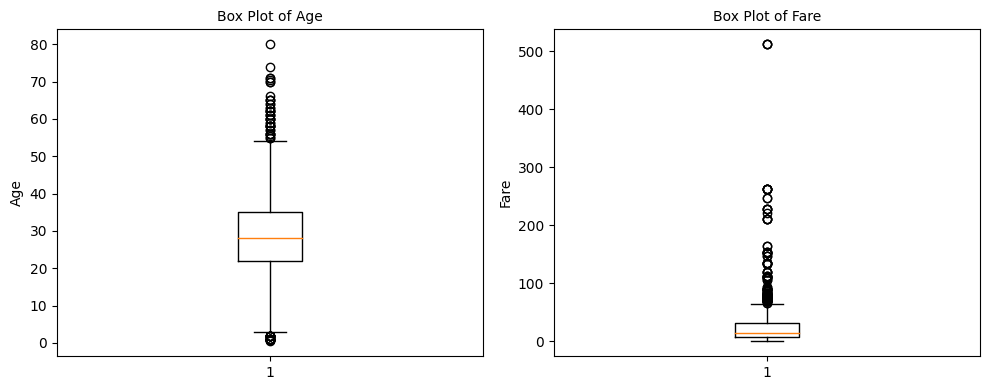

In [16]:
plt.figure(figsize=(10, 4))

# --- First Subplot: Box Plot for Age ---
plt.subplot(1, 2, 1) # (number of rows, number of columns, plot number)
plt.boxplot(train['Age'].dropna())
plt.title('Box Plot of Age', fontsize=10)
plt.ylabel('Age', fontsize=10)

# --- Second Subplot: Box Plot for Fare ---
plt.subplot(1, 2, 2)
plt.boxplot(train['Fare'].dropna())
plt.title('Box Plot of Fare', fontsize=10)
plt.ylabel('Fare', fontsize=10)

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()

# Show the combined plot
plt.show()

### Correlation Analysis
The correlation matrix shows how numeric features relate to survival. Notably, Sex (female) has a strong positive correlation with survival (0.54), while Sex (male) has a strong negative correlation (-0.54). Pclass and Fare also have moderate correlations with survival (-0.34 and 0.26, respectively). Other features show weaker correlations, suggesting they may not be strong predictors on their own.

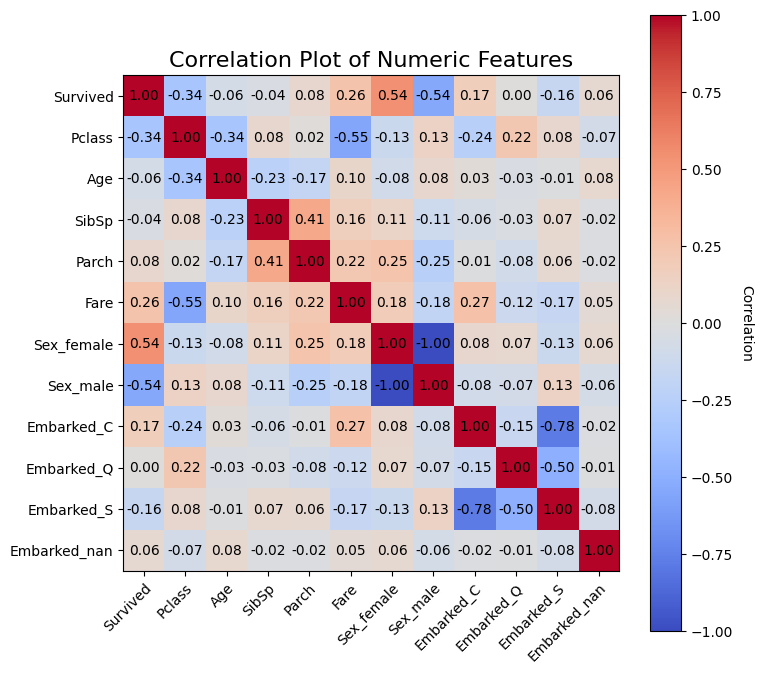

In [17]:
# Correlation Analysis
features_to_drop = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

correlation_matrix = train.drop(columns = features_to_drop).dropna().corr()

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(correlation_matrix, cmap="coolwarm")

# Add a color bar to the plot to show the scale
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom")

# Set the ticks and labels for the axes
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.index)

# Rotate the x-axis tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over the data and create text annotations to display the values
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        text = ax.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black")


# Show plot
plt.title('Correlation Plot of Numeric Features', fontsize=16)
plt.show()

### Model Training

In [18]:
X = train.drop(columns = ['Survived'] + features_to_drop)
X_test = test.drop(columns = features_to_drop)
y = train["Survived"]

In [22]:
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0
887,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0
888,3,28.0,1,2,23.4500,1.0,0.0,0.0,0.0,1.0,0.0
889,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0


In [19]:
# Last control before model fitting. Make sure there are no missing values.
# X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    float64
 2   SibSp         418 non-null    int64  
 3   Parch         418 non-null    int64  
 4   Fare          418 non-null    float64
 5   Sex_female    418 non-null    float64
 6   Sex_male      418 non-null    float64
 7   Embarked_C    418 non-null    float64
 8   Embarked_Q    418 non-null    float64
 9   Embarked_S    418 non-null    float64
 10  Embarked_nan  418 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 36.1 KB


In [20]:
# --- Cross-Validation ---
model = LinearSVC(max_iter=10000) # Added parameters to handle convergence warnings
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Scores for each fold:", scores)
print("Mean Accuracy:", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Scores for each fold: [0.77653631 0.79213483 0.78089888 0.75842697 0.80898876]
Mean Accuracy: 0.7833971502102818
Standard Deviation of Accuracy: 0.016781539372217495


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [21]:
model.fit(X, y)
predictions = model.predict(X_test)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.head()
output.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
